# ch.6 학습 관련 기술들 # 

## 6.2 가중치의 초기값 ##

활성화 값의 초기값에 따른 학습차이를 알아보기 위해 ch5에서 만들었던 mnist용 2층 신경망과 추가로 만들어본 5층 신경망을 그대로 가져왔다. 이 신경망에 단순히 random.randn()의 표준편차를 조절한것이 아닌 Xavier, He를 적용해보도록 하겠다. (표준편차를 조절해본것은  1-5에 있다.)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.append(os.getcwd())

In [2]:
class ReLu:
    # np.array 형태의 input, output을 가정
    def __init__(self):
        self.mask = None # 0보다 큰지 작은지 저장
        
    def forward(self,x):
        self.mask = (x <= 0)
        out = x.copy()  # shallow copy
        out[self.mask] = 0 # mask 가 true일때 0을 return 하도록
        
        return out
    
    def backward(self,dout):
        dout[self.mask] = 0 
        dx = dout # 나머지는 *1 이라 변화 없음
        
        return dx

In [3]:
class sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1/(1+exp(-x))
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) *self.out
        
        return dx        

In [4]:
class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.X = None
        self.dW = None
        self.db = None
        
    def forward(self,X):
        self.X = X
        out = np.dot(X,self.W)+self.b  
        
        return out
    
    def backward(self,dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout) # 순서주의
        self.db = np.sum(dout, axis = 0) # 상류의 dout을 데이터마다 더함
        
        return dX

In [5]:
from scratch.common.functions import softmax, cross_entropy_error
from scratch.common.gradient import numerical_gradient
from scratch.dataset.mnist import load_mnist
from collections import OrderedDict

In [6]:
class SoftmaxWithLoss:
    def __init_(self):
        self.loss = None
        self.y = None # softmax결과
        self.t = None # 정답
        
    def forward(self, x, t): # 추정치, 정답
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout = 1): # dL/dL =1
        batch_size = self.t.shape[0] # 데이터 수
        dx = (self.y -self.t)/batch_size # 부록 A 291p참고
        
        return dx

In [7]:
class TwoLayerNet: # 은닉층 1개
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01, init_type='std'):
        
        # parameter 초기화
        self.params={}

        if init_type=='std':
            #standard deviation 이용 초기값   
            pass 
        
            self.params['W1'] = weight_init_std * np.random.randn(input_size,hidden_size)
            self.params['W2'] = weight_init_std * np.random.randn(hidden_size,output_size)

        elif init_type=='Xavier':
            #Xavier 초기값        
            self.params['W1'] = np.random.randn(input_size,hidden_size)/np.sqrt(input_size)
            self.params['W2'] = np.random.randn(hidden_size,output_size)/np.sqrt(hidden_size)

        elif init_type=='He':
            #He 초기값
            self.params['W1'] = np.sqrt(2)*np.random.randn(input_size,hidden_size)/np.sqrt(input_size)
            self.params['W2'] = np.sqrt(2)*np.random.randn(hidden_size,output_size)/np.sqrt(hidden_size)
        
        else:
            raise Exception("매개변수 초기화 방식 잘못 입력함")
        
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)
    
        # 계층 만들기
        self.layers = OrderedDict() # 순서가 있는 dictionary -> 추가한 순서를 기억한다.
        self.layers['Affine1'] = Affine(self.params['W1'],self.params['b1'])
        self.layers['ReLu1'] = ReLu()
        self.layers['Affine2'] = Affine(self.params['W2'],self.params['b2'])
        self.layers['ReLu2'] = ReLu()
        self.lastLayer = SoftmaxWithLoss()
        
        
        # 활성화값 확일을 위한 공간
        self.activation = {}
        
    def predict(self, x):
        for layer in self.layers.values(): # layers는 dictionary 이므로 values()필요
            x = layer.forward(x) # 각 계층에 forward가 구현되어 있음
            
            # 활성화 값 확인을 위해
            if isinstance(layer,ReLu):
                self.activation[layer]=x
            
        return x # 모든 layer를 지난 결과
    
    def loss(self, x, t):
        y = self.predict(x) # 추정치
        
        return self.lastLayer.forward(y,t)
        
    def accuracy(self, x, t):      # 전체 데이터 중에서 올바른 추정 비율
        y = self.predict(x)        # 출력 (1 x n)  # 각 label별 계산 결과
        y = np.argmax(y, axis = 1) # 1x1 로 변환
        
        if t.ndim != 1: t = np.argmax(t, axis = 1)  # 1x1 형태로 변환 (원래 one hot vector 형태였음)
            
        accuracy = np.sum(y==t) / float(x.shape[0]) # 올바른 추정 수 /전체 데이터 수
        
        return accuracy
    
    # ch.4 방식 - 직접 gradient 계산하기
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W: self.loss(x,t)
        
        grads={}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    # 오차 역전파를 이용한 gradient 구하기
    def gradient(self, x, t):
        
        #  순전파
        self.loss(x, t)
        
        # dL/dL = 1
        dout = 1            
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values()) # 순서를 뒤집기 위해 list로 변경
        layers.reverse()
        
        # 역전파 진행
        for layer in layers:
            dout = layer.backward(dout)
            # backward를 진행하면서 각 layer내 dX,dY등이 업데이트 됨 (저장됨)
            
        # 결과 저장
        grads={}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads 

In [8]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iteration = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list=[[],[],[]]
train_acc_list=[]
test_acc_list=[]
last_acc_list=[]

iter_per_epoch = max(train_size/batch_size, 1) # 몇번의 batch선택을 해야되는지 / batch size가 전체 data보다 작을수도 있으니 확인


for j in range(5):
    network_std = TwoLayerNet(input_size = 784, hidden_size=50, output_size = 10) 
    network_X = TwoLayerNet(input_size = 784, hidden_size=50, output_size = 10, init_type='Xavier') 
    network_He = TwoLayerNet(input_size = 784, hidden_size=50, output_size = 10, init_type='He') 

    for i in range(iteration):
        # mini batch생성
        batch_mask = np.random.choice(train_size, batch_size) # 무작위로 100개의 데이터 선택
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # gradient구하기 (오차 역전파법)
        grad_std = network_std.gradient(x_batch, t_batch)
        grad_X = network_std.gradient(x_batch, t_batch)
        grad_He = network_std.gradient(x_batch, t_batch)

        # parameter update
        for key in ('W1','b1','W2','b2'):
            network_std.params[key] -= learning_rate * grad_std[key]
            network_X.params[key] -= learning_rate * grad_X[key]
            network_He.params[key] -= learning_rate * grad_He[key]

        # 업데이트된 parameter로 loss 계산
        loss = network_std.loss(x_batch, t_batch)
        train_loss_list[0].append(loss)

        loss = network_X.loss(x_batch, t_batch)
        train_loss_list[1].append(loss)

        loss = network_He.loss(x_batch, t_batch)
        train_loss_list[2].append(loss)

        if i%1000==0 or i==(iteration-1):
            # 전체 데이터를 학습에 사용하고 나면 전체 데이터에 대한 정확도 계산
            train_acc = [network_std.accuracy(x_train, t_train) ,network_X.accuracy(x_train, t_train) ,network_He.accuracy(x_train, t_train)] 
            test_acc = [network_std.accuracy(x_test, t_test), network_X.accuracy(x_test, t_test), network_He.accuracy(x_test, t_test)]
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)


    last_acc_list.append(test_acc)
    print(test_acc)
    
print('5회평균 정확도:',np.average(last_acc_list, axis=0))

[0.9712, 0.9481, 0.9206]
[0.5706, 0.6505, 0.5321]
[0.7612, 0.7417, 0.7633]
[0.7802, 0.8099, 0.8004]
[0.6847, 0.7014, 0.6619]
5회평균 정확도: [0.75358 0.77032 0.73566]


In [9]:
[784]+[100,100,100,100]+[10]

[784, 100, 100, 100, 100, 10]

### 2층 신경망에 std = 0.01을 활성화값의 초기값으로 사용했을때 학습후 활성화 값의 분포 ###

(array([5.54042e+05, 2.76000e+02, 2.60000e+02, 2.67000e+02, 2.82000e+02,
        2.49000e+02, 2.65000e+02, 2.67000e+02, 2.42000e+02, 2.63000e+02,
        2.40000e+02, 2.45000e+02, 2.57000e+02, 2.39000e+02, 2.25000e+02,
        2.21000e+02, 2.29000e+02, 2.09000e+02, 2.05000e+02, 1.87000e+02,
        2.20000e+02, 2.18000e+02, 2.04000e+02, 2.12000e+02, 2.29000e+02,
        2.19000e+02, 2.09000e+02, 2.23000e+02, 1.93000e+02, 1.97000e+02]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

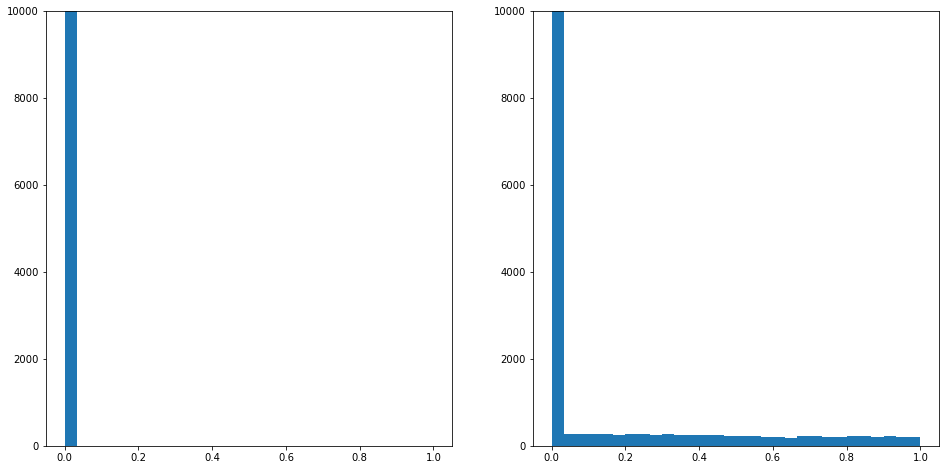

In [48]:
# std = 0.01 초기값 사용시 2층 신경망의 활성화값 변화 (시작시)->(10000회의 반복문이 끝난후) 정확도 57퍼센트
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.ylim(0,10000)
plt.hist(network.activation[5].flatten(),30,range=(0,1))

plt.subplot(1,2,2)
plt.ylim(0,10000)
plt.hist(network.activation[-3].flatten(),30,range=(0,1))

### 2층 신경망에 Xavier을 활성화값의 초기값으로 사용했을때 학습후 활성화 값의 분포 ###

(array([445326.,    901.,    888.,    890.,    912.,    890.,    888.,
           889.,    800.,    858.,    838.,    830.,    849.,    885.,
           825.,    824.,    813.,    796.,    810.,    844.,    806.,
           828.,    815.,    785.,    841.,    794.,    827.,    787.,
           795.,    783.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

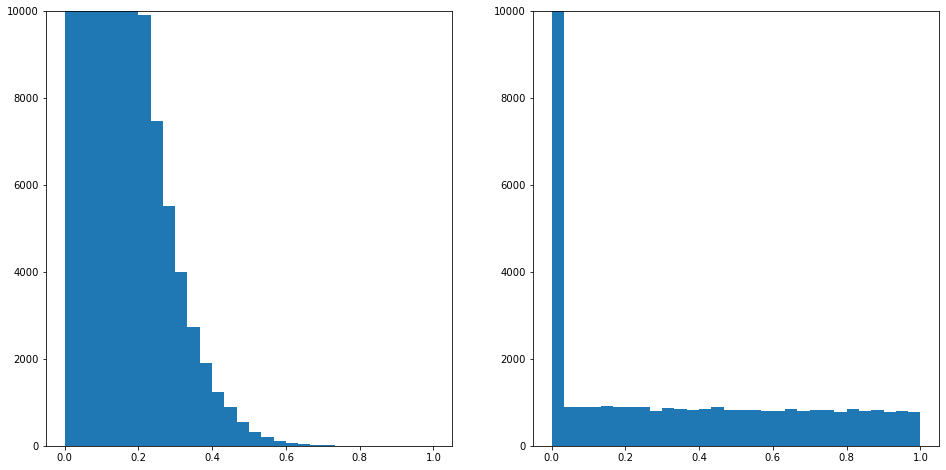

In [44]:
# Xavier 초기값 사용시 2층 신경망의 활성화값 변화 (시작시)->(10000회의 반복문이 끝난후) 정확도 77퍼센트
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.ylim(0,10000)
plt.hist(network.activation[5].flatten(),30,range=(0,1))

plt.subplot(1,2,2)
plt.ylim(0,10000)
plt.hist(network.activation[-3].flatten(),30,range=(0,1))

### 2층 신경망에 He을 활성화값의 초기값으로 사용했을때 학습후 활성화 값의 분포 ###

(array([207252.,   1485.,   1556.,   1568.,   1527.,   1548.,   1665.,
          1544.,   1587.,   1696.,   1623.,   1593.,   1621.,   1598.,
          1682.,   1568.,   1630.,   1675.,   1579.,   1691.,   1643.,
          1644.,   1668.,   1709.,   1712.,   1721.,   1685.,   1734.,
          1640.,   1706.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

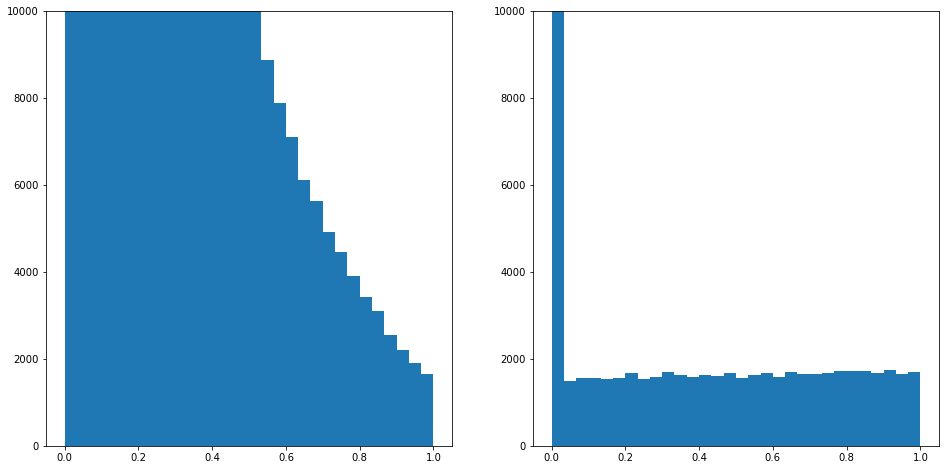

In [52]:
# He 초기값 사용시 2층 신경망의 활성화값 변화 (시작시)->(10000회의 반복문이 끝난후) 정확도 97퍼센트
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.ylim(0,10000)
plt.hist(network.activation[5].flatten(),30,range=(0,1))

plt.subplot(1,2,2)
plt.ylim(0,10000)
plt.hist(network.activation[-3].flatten(),30,range=(0,1))

### 초기화 방식에 따른 활성화값 분포 요약 ###

In [ ]:
plt.figure(figsize=(16,8))
for i,key in enumerate(network_std.activation.keys()):
    plt.subplot(3,2,i+1)
    plt.title('layer'+str(i+1))
    plt.ylim(0,7000)
    plt.hist(network_std.activation[key].flatten(),30,range=(0,1))
    
    plt.subplot(3,2,i+3)
    plt.title('layer'+str(i+1))
    plt.ylim(0,7000)
    plt.hist(network_X.activation[key].flatten(),30,range=(0,1))
    
    plt.subplot(3,2,i+5)
    plt.title('layer'+str(i+1))
    plt.ylim(0,7000)
    plt.hist(network_He.activation[key].flatten(),30,range=(0,1))

### 2층 신경망의 parameter 초기화 방식에 따른 정확도 변화 ###

In [58]:
test_acc_list = np.array(test_acc_list)

In [59]:
test_acc_list

array([[0.1402, 0.1442, 0.0606],
       [0.5518, 0.6392, 0.5063],
       [0.5604, 0.6325, 0.5404],
       [0.5645, 0.6441, 0.5853],
       [0.565 , 0.628 , 0.5825],
       [0.5685, 0.6128, 0.6132],
       [0.5706, 0.6136, 0.6306],
       [0.5721, 0.6087, 0.6425],
       [0.5727, 0.5924, 0.6438],
       [0.5738, 0.5972, 0.6444],
       [0.6682, 0.6693, 0.6931],
       [0.1688, 0.1028, 0.0921],
       [0.7347, 0.6824, 0.5981],
       [0.75  , 0.7254, 0.6463],
       [0.758 , 0.7305, 0.6675],
       [0.7618, 0.7432, 0.6694],
       [0.7744, 0.7968, 0.7689],
       [0.7759, 0.801 , 0.7564],
       [0.7783, 0.8101, 0.77  ],
       [0.7801, 0.8008, 0.7797],
       [0.783 , 0.7972, 0.7958],
       [0.7832, 0.7999, 0.781 ],
       [0.1018, 0.0993, 0.068 ],
       [0.9098, 0.8832, 0.6293],
       [0.9316, 0.9101, 0.7047],
       [0.9448, 0.9249, 0.7488],
       [0.9522, 0.9334, 0.7797],
       [0.9586, 0.9404, 0.8184],
       [0.9624, 0.9405, 0.8271],
       [0.9633, 0.9389, 0.8011],
       [0.

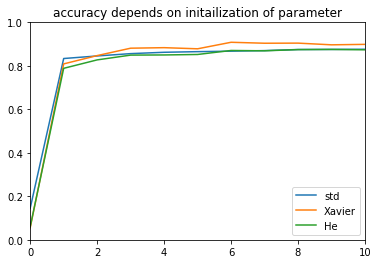

In [65]:
plt.title('accuracy depends on initailization of parameter')
plt.plot(range(0,11),test_acc_list[:,0][44:55],label='std')
plt.plot(range(0,11),test_acc_list[:,1][44:55],label='Xavier')
plt.plot(range(0,11),test_acc_list[:,2][44:55],label='He')
plt.ylim((0,1))
plt.xlim((0,10))
plt.legend()

## 5층 신경망에 다양한 초기화 방식 적용 해보기 ##

In [8]:
class FiveLayerNet: # 은닉층 4개
    def __init__(self, i, h1, h2, h3, h4, o, weight_init_std = 0.01, init_type = 'std'):
        
        # parameter 초기화
        self.params={}
        
        if init_type == 'std':
            # std = 0.01        
            self.params['W1'] = weight_init_std*np.random.randn(i,h1)
            self.params['W2'] = weight_init_std*np.random.randn(h1,h2)
            self.params['W3'] = weight_init_std*np.random.randn(h2,h3)
            self.params['W4'] = weight_init_std*np.random.randn(h3,h4)
        
        elif init_type == 'Xavier':
            # Xavier       
            self.params['W1'] = np.random.randn(i,h1)/np.sqrt(i)
            self.params['W2'] = np.random.randn(h1,h2)/np.sqrt(h1)
            self.params['W3'] = np.random.randn(h2,h3)/np.sqrt(h2)
            self.params['W4'] = np.random.randn(h3,h4)/np.sqrt(h3)
        
        elif init_type == 'He':
            # He        
            self.params['W1'] = np.sqrt(2)*np.random.randn(i,h1)/np.sqrt(i)
            self.params['W2'] = np.sqrt(2)*np.random.randn(h1,h2)/np.sqrt(h1)
            self.params['W3'] = np.sqrt(2)*np.random.randn(h2,h3)/np.sqrt(h2)
            self.params['W4'] = np.sqrt(2)*np.random.randn(h3,h4)/np.sqrt(h3)
        
        else:
            raise Exception("잘못된 가중치 초기화 방식")

        self.params['W5'] = weight_init_std*np.random.randn(h4,o)
        
        self.params['b1'] = np.zeros(h1)
        self.params['b2'] = np.zeros(h2)
        self.params['b3'] = np.zeros(h3)
        self.params['b4'] = np.zeros(h4)
        self.params['b5'] = np.zeros(o)
    
        # 계층 만들기
        self.layers = OrderedDict() # 순서가 있는 dictionary -> 추가한 순서를 기억한다.
        self.layers['Affine1'] = Affine(self.params['W1'],self.params['b1'])
        self.layers['ReLu1'] = ReLu()
        
        self.layers['Affine2'] = Affine(self.params['W2'],self.params['b2'])
        self.layers['ReLu2'] = ReLu()
        
        self.layers['Affine3'] = Affine(self.params['W3'],self.params['b3'])
        self.layers['ReLu3'] = ReLu()
        
        self.layers['Affine4'] = Affine(self.params['W4'],self.params['b4'])
        self.layers['ReLu4'] = ReLu()
        
        self.layers['Affine5'] = Affine(self.params['W5'],self.params['b5'])
        self.layers['ReLu5'] = ReLu()
        
        self.lastLayer = SoftmaxWithLoss()
        
        # 활성화값 저장을 위한 공간
        self.activation = {}
        
        
    def predict(self, x):
        for index,layer in enumerate(self.layers.values()): # layers는 dictionary 이므로 values()필요
            x = layer.forward(x) # 각 계층에 forward가 구현되어 있음
            
            if isinstance(layer,ReLu):
                self.activation[index] = x
            
        return x # 모든 layer를 지난 결과
    
    def loss(self, x, t):
        y = self.predict(x) # 추정치
        
        return self.lastLayer.forward(y,t)
        
    def accuracy(self, x, t):      # 전체 데이터 중에서 올바른 추정 비율
        y = self.predict(x)        # 출력 (1 x n)  # 각 label별 계산 결과
        y = np.argmax(y, axis = 1) # 1x1 로 변환
        
        if t.ndim != 1: t = np.argmax(t, axis = 1)  # 1x1 형태로 변환 (원래 one hot vector 형태였음)
            
        accuracy = np.sum(y==t) / float(x.shape[0]) # 올바른 추정 수 /전체 데이터 수
        
        return accuracy
    
    # ch.4 방식 - 직접 gradient 계산하기
    def numerical_gradient(self, x, t):
        
        loss_W = lambda W: self.loss(x,t)
        
        grads={}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])
        grads['W5'] = numerical_gradient(loss_W, self.params['W5'])
        grads['b5'] = numerical_gradient(loss_W, self.params['b5'])
        
        return grads
        
    # 오차 역전파를 이용한 gradient 구하기
    def gradient(self, x, t):
        
        #  순전파
        self.loss(x, t)
        
        # dL/dL = 1
        dout = 1            
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values()) # 순서를 뒤집기 위해 list로 변경
        layers.reverse()
        
        # 역전파 진행
        for layer in layers:
            dout = layer.backward(dout)
            # backward를 진행하면서 각 layer내 dX,dY등이 업데이트 됨 (저장됨)
            
        # 결과 저장
        grads={}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db
        grads['W4'] = self.layers['Affine4'].dW
        grads['b4'] = self.layers['Affine4'].db
        grads['W5'] = self.layers['Affine5'].dW
        grads['b5'] = self.layers['Affine5'].db
        
        return grads 

In [9]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [10]:
iteration = 5000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list=[[],[],[]]
train_acc_list=[[],[],[]]
test_acc_list=[[],[],[]]
last_acc_list=[[],[],[]]

iter_per_epoch = max(train_size/batch_size, 1) # 몇번의 batch선택을 해야되는지 / batch size가 전체 data보다 작을수도 있으니 확인

# for k in range(5):

network_std = FiveLayerNet(i=784,h1=500,h2=250,h3=100,h4=40,o=10)
network_X = FiveLayerNet(i=784,h1=500,h2=250,h3=100,h4=40,o=10, init_type = 'Xavier')
network_He = FiveLayerNet(i=784,h1=500,h2=250,h3=100,h4=40,o=10, init_type = 'He')

for i in range(iteration):
    # mini batch생성
    batch_mask = np.random.choice(train_size, batch_size) # 무작위로 100개의 데이터 선택
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # gradient구하기 (오차 역전파법)
    grad_std = network_std.gradient(x_batch, t_batch)
    grad_X = network_X.gradient(x_batch, t_batch)
    grad_He = network_He.gradient(x_batch, t_batch)

    # parameter update
    for key in ('W1','b1','W2','b2'):
        network_std.params[key] -= learning_rate * grad_std[key]
        network_X.params[key] -= learning_rate * grad_X[key]
        network_He.params[key] -= learning_rate * grad_He[key]

    # 업데이트된 parameter로 loss 계산
    loss = network_std.loss(x_batch, t_batch)
    train_loss_list[0].append(loss)

    loss = network_X.loss(x_batch, t_batch)
    train_loss_list[1].append(loss)

    loss = network_He.loss(x_batch, t_batch)
    train_loss_list[2].append(loss)

    if i%iter_per_epoch==0 or i==(iteration-1):
        print(i)
        # 전체 데이터를 학습에 사용하고 나면 전체 데이터에 대한 정확도 계산
#         train_acc = network_std.accuracy(x_train, t_train) 
#         test_acc = network_std.accuracy(x_test, t_test)
        train_acc_list[0].append( network_std.accuracy(x_train, t_train) )
        test_acc_list[0].append( network_std.accuracy(x_test, t_test) )
        
        train_acc_list[1].append( network_X.accuracy(x_train, t_train))
        test_acc_list[1].append( network_X.accuracy(x_test, t_test))
        
        train_acc_list[2].append( network_He.accuracy(x_train, t_train))
        test_acc_list[2].append( network_He.accuracy(x_test, t_test))

#     last_acc_list.append(test_acc)
    
# print('5회평균 정확도:',np.average(last_acc_list))

0
600
1200
1800
2400
3000
3600
4200
4800
4999


In [11]:
len(network_std.activation)

5

### 활성화값 분포 ###

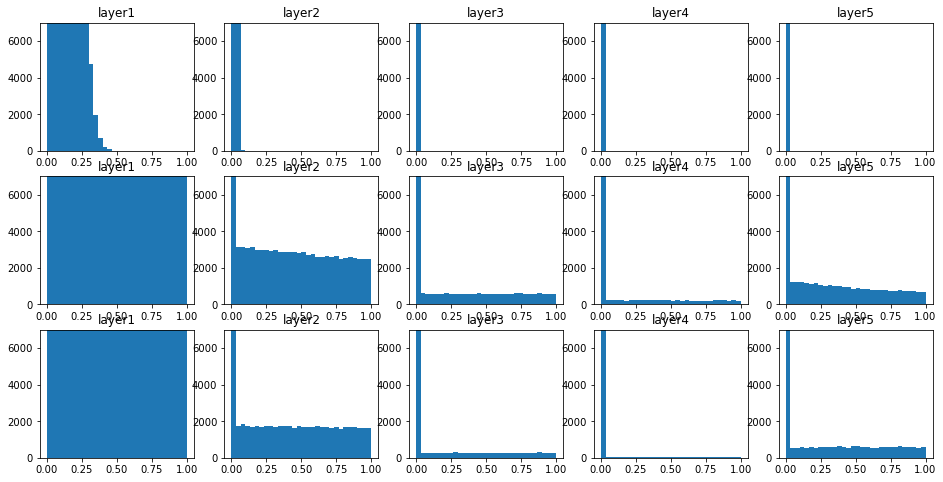

In [38]:
plt.figure(figsize=(16,8))
for i,key in enumerate(network_std.activation.keys()):
    plt.subplot(3,5,i+1)
    plt.title('layer'+str(i+1))
    plt.ylim(0,7000)
    plt.hist(network_std.activation[key].flatten(),30,range=(0,1))
    
    plt.subplot(3,5,i+6)
    plt.title('layer'+str(i+1))
    plt.ylim(0,7000)
    plt.hist(network_X.activation[key].flatten(),30,range=(0,1))
    
    plt.subplot(3,5,i+11)
    plt.title('layer'+str(i+1))
    plt.ylim(0,7000)
    plt.hist(network_He.activation[key].flatten(),30,range=(0,1))

In [13]:
len(test_acc_list[0])

10

### 정확도 변화 ###

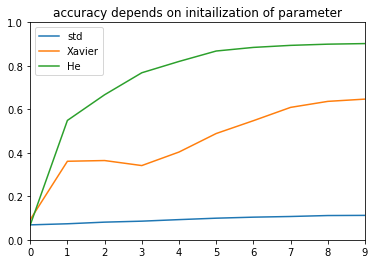

In [40]:
plt.title('accuracy depends on initailization of parameter')
plt.plot(range(0,10),test_acc_list[0],label='std')
plt.plot(range(0,10),test_acc_list[1],label='Xavier')
plt.plot(range(0,10),test_acc_list[2],label='He')
plt.ylim((0,1))
plt.xlim((0,9))
plt.legend()

### 배치 정규화/ 가중치 감소/ 드롭아웃 / 5-fold

따로 파일을 만들어서 진행함.